In [1]:
!python -m pip install xgboost

In [12]:
!python -m pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from utils import LoadRumoursDataset,LoadRumoursDatasetFilterNode
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
import uuid
from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

In [8]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
#mlflow.set_experiment("Xgboost experiments 2024-09-26 SMOTE")

In [2]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"


### SMOTE APPROACH

In [3]:
time_cut =(24*60*3)
processor = LoadRumoursDatasetFilterNode(file_path_replies, file_path_posts, time_cut)
processor.load_data()
processor.process_data()
df_final = processor.get_final_dataframe()


In [4]:
df_final

,followers,favorite_count,retweet_count,rumour,embeddings_avg,replies,first_time_diff,no_verified,verified
0,-0.073004,-0.532290,-0.160000,1,"[-0.12270056130364537, 0.01583862374536693, -0...",5,3.510619,1,0
1,0.031065,-0.344423,1.293333,1,"[-0.12335950043052435, -0.055849663292368255, ...",5,0.999077,0,1
2,0.356672,-0.524462,-0.302222,1,"[-0.1364929385483265, -0.07159566258390744, -0...",5,0.740536,0,1
3,0.332156,-0.524462,-0.400000,1,"[-0.045377860377941816, -0.20127306692302227, ...",3,-0.164358,0,1
4,1.046022,-0.391389,0.964444,1,"[-0.03706469060853124, -0.1309182441327721, -0...",10,-0.352724,0,1
...,...,...,...,...,...,...,...,...,...
1997,3.895910,-0.140900,-0.124444,0,"[0.21622000262141228, -0.15450449846684933, -0...",8,0.204986,0,1
1998,10.452911,3.859100,5.213333,0,"[0.21485890651291067, 0.03315381561829285, -0....",9,-0.245614,0,1
1999,0.012322,1.189824,0.955556,0,"[0.08846200071275234, -0.1485882457345724, 0.1...",9,0.500462,1,0
2000,3.631498,0.477495,1.075556,0,"[0.021962551607025996, -0.019428667094972398, ...",18,-0.271468,0,1


In [10]:
X  = df_final.drop(columns=['rumour'])
X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
#X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y =df_final['rumour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True
)

In [14]:
print(y_train.sum(),y_train.shape)

357 (1601,)


In [15]:
print(y_test.sum(),y_test.shape)

90 (401,)


In [11]:
# Apply SMOTE to the features without embeddings
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [17]:
X_resampled.shape

(2488, 107)

In [18]:
print(y_resampled.sum(),y_resampled.shape)

1244 (2488,)


#### Hyperparameter tunning

In [12]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
     'max_depth': [3, 4, 5, 6],
    'learning_rate': np.linspace(0.001, 0.1, 20),
    'n_estimators': [20,50, 100, 150, 200]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='f1')


In [13]:
# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_resampled, y_resampled)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.07915789473684211}
Best score:  0.9343967429206297


In [14]:
best_params = random_search.best_params_

In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]

    # Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='recall')
    
    # Print model report for Train:
    print("\nModel Report Train")
    print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
    print("Recall : %f" % recall_score(y_train, dtrain_predictions))
    

    
    # Print model report for Test:
    print("\nModel Report Test")
    print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
    print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
    print("Recall : %f" % recall_score(y_test, dtest_predictions))
    

    
    plt.tight_layout()
    plt.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    return alg



In [29]:
best_params={
             'n_estimators': 50, 
             'max_depth': 3, 
             'learning_rate': 0.05, 
       }

In [30]:
# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(
    eval_metric='logloss',
    **best_params
)
final_model.fit(X_resampled, y_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [23]:
modelfit(final_model,X_resampled, y_resampled,X_test,y_test)


Model Report Train
AUC Score : 0.966499
Accuracy : 0.8967
Precision : 0.8675
Recall : 0.936495

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


<Figure size 640x480 with 0 Axes>

CV Score : Mean - 0.9035303 | Std - 0.02317016 | Min - 0.8634538 | Max - 0.9317269


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [24]:
modelfit(final_model,X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.953527
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


<Figure size 640x480 with 0 Axes>

CV Score : Mean - 0.579734 | Std - 0.03872896 | Min - 0.5352113 | Max - 0.6338028


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

#### Without SMOTE

In [25]:
# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(
    eval_metric='logloss',
    **best_params
)
final_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [26]:
modelfit(final_model, X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.961131
Accuracy : 0.9032
Precision : 0.8459
Recall : 0.691877

Model Report Test
AUC Score : 0.889711
Accuracy : 0.8329
Precision : 0.6494
Recall : 0.555556


<Figure size 640x480 with 0 Axes>

CV Score : Mean - 0.579734 | Std - 0.03872896 | Min - 0.5352113 | Max - 0.6338028


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

#### SMOTE and generic Xgboost pipeline

In [27]:
# Train the final model with the best hyperparameters
params =   {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.05,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0.5
}
final_model = xgb.XGBClassifier(
    eval_metric='logloss',
    **params
)
final_model.fit(X_resampled, y_resampled)


XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

In [28]:
modelfit(final_model, X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.998653
Accuracy : 0.9788
Precision : 0.913
Recall : 1.000000

Model Report Test
AUC Score : 0.906217
Accuracy : 0.8304
Precision : 0.5917
Recall : 0.788889


<Figure size 640x480 with 0 Axes>

CV Score : Mean - 0.6272692 | Std - 0.04357213 | Min - 0.5633803 | Max - 0.6944444


XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

#### General Parameters:

* objective: "binary:logistic" (since it's a binary classification problem)
*  eval_metric: "logloss" (logarithmic loss is a good measure for classification)
  
#### Tree Booster Parameters:
* max_depth: 4 (shallower trees to prevent overfitting)
* learning_rate: 0.05 (a lower learning rate helps the model generalize better)
* n_estimators: 100 (start with fewer trees to prevent overfitting on a small dataset)
* subsample: 0.8 (use 80% of the data for each boosting round to introduce randomness)
* colsample_bytree: 0.8 (use 80% of the features, useful with high-dimensional embeddings)

#### Regularization Parameters:
* gamma: 0.1 (penalty for additional leaf nodes, controls tree complexity)
* min_child_weight: 1 (controls the minimum sum of instance weight in a child, useful for preventing overfitting)
* lambda: 1 (L2 regularization to reduce overfitting)
* alpha: 0.5 (L1 regularization for feature selection)
  


In [34]:
def modelfit(alg, X_train, y_train, X_test, y_test, printFeatureImportance=True):
    with mlflow.start_run():
        # Fit the algorithm on the data
        #alg.fit(X_resampled, y_resampled)
            
        # Predict training set:
        dtrain_predictions = alg.predict(X_train)
        dtrain_predprob = alg.predict_proba(X_train)[:, 1]

        # Predict test set:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:, 1]

        # Log model parameters
        mlflow.log_params(alg.get_params())

        # Log metrics for Train
        mlflow.log_metric("train_auc", roc_auc_score(y_train, dtrain_predprob))
        mlflow.log_metric("train_accuracy", accuracy_score(y_train, dtrain_predictions))
        mlflow.log_metric("train_precision", precision_score(y_train, dtrain_predictions))
        mlflow.log_metric("train_recall", recall_score(y_train, dtrain_predictions))

        # Log metrics for Test
        mlflow.log_metric("test_auc", roc_auc_score(y_test, dtest_predprob))
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, dtest_predictions))
        mlflow.log_metric("test_precision", precision_score(y_test, dtest_predictions))
        mlflow.log_metric("test_recall", recall_score(y_test, dtest_predictions))

        # Print model report for Train
        print("\nModel Report Train")
        print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
        print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
        print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
        print("Recall : %f" % recall_score(y_train, dtrain_predictions))

      

        # Log confusion matrix for Train
        train_cm = confusion_matrix(y_train, dtrain_predictions)
        mlflow.log_artifact(plot_confusion_matrix(train_cm, "Train"))

        # Print model report for Test
        print("\nModel Report Test")
        print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
        print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
        print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
        print("Recall : %f" % recall_score(y_test, dtest_predictions))


        # Log the model with input example
        input_example = X_train[0:1]   # Use the first row of X_train as an example
        mlflow.sklearn.log_model(alg, "model", input_example=input_example)
        mlflow.log_metric("time_cut", time_cut)
    
    # Explicitly end the MLflow run
    mlflow.end_run()

    return alg



In [35]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("Xgboost SMOTE Filter Node 2024-09-30 10 min-3days")

2024/10/01 01:28:56 INFO mlflow.tracking.fluent: Experiment with name 'Xgboost SMOTE Filter Node 2024-09-30 10 min-3days' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/33', creation_time=1727746136710, experiment_id='33', last_update_time=1727746136710, lifecycle_stage='active', name='Xgboost SMOTE Filter Node 2024-09-30 10 min-3days', tags={}>

In [36]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(10,24*3*60,10):
    print(time_cut)
    processor = LoadRumoursDatasetFilterNode(file_path_replies, file_path_posts, time_cut)
    processor.load_data()
    processor.process_data()
    df_final = processor.get_final_dataframe()

    X  = df_final.drop(columns=['rumour'])
    X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
    y =df_final['rumour']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True
    )

    if time_cut >20:

        smote = SMOTE(random_state=42,sampling_strategy='minority')
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        final_model = xgb.XGBClassifier(
        eval_metric='logloss',
        **best_params
        )
        
        final_model.fit(X_resampled, y_resampled)
        
        
        modelfit(final_model,  X_train, y_train,X_test,y_test)
    else:

        final_model = xgb.XGBClassifier(
        eval_metric='logloss',
        **best_params
        )
        
        final_model.fit(X_train, y_train)  
        
        modelfit(final_model,  X_train, y_train,X_test,y_test)

10

Model Report Train
AUC Score : 0.500000
Accuracy : 0.75
Precision : 0.75
Recall : 1.000000

Model Report Test
AUC Score : 0.500000
Accuracy : 0.6667
Precision : 0.6667
Recall : 1.000000


/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


20

Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.888889
Accuracy : 0.6667
Precision : 0.6
Recall : 1.000000


30

Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.866667
Accuracy : 0.7273
Precision : 0.6667
Recall : 1.000000


40

Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.777778
Accuracy : 0.7333
Precision : 0.6923
Recall : 1.000000


50

Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.869318
Accuracy : 0.8947
Precision : 0.8462
Recall : 1.000000


60

Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.878788
Accuracy : 0.8696
Precision : 0.8
Recall : 1.000000


70

Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.887574
Accuracy : 0.7308
Precision : 0.7143
Recall : 0.769231


80

Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.857778
Accuracy : 0.7333
Precision : 0.7333
Recall : 0.733333


90

Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.841176
Accuracy : 0.7838
Precision : 0.8
Recall : 0.705882


100

Model Report Train
AUC Score : 0.999603
Accuracy : 0.9886
Precision : 0.9865
Recall : 0.986486

Model Report Test
AUC Score : 0.914980
Accuracy : 0.7778
Precision : 0.7143
Recall : 0.789474


110

Model Report Train
AUC Score : 0.999678
Accuracy : 0.9898
Precision : 0.9873
Recall : 0.987342

Model Report Test
AUC Score : 0.930000
Accuracy : 0.86
Precision : 0.8095
Recall : 0.850000


120

Model Report Train
AUC Score : 0.999735
Accuracy : 0.9864
Precision : 0.9756
Recall : 0.987654

Model Report Test
AUC Score : 0.926389
Accuracy : 0.8571
Precision : 0.7727
Recall : 0.850000


130

Model Report Train
AUC Score : 0.999791
Accuracy : 0.9921
Precision : 0.9885
Recall : 0.988506

Model Report Test
AUC Score : 0.961197
Accuracy : 0.8413
Precision : 0.7143
Recall : 0.909091


140

Model Report Train
AUC Score : 0.998970
Accuracy : 0.9822
Precision : 0.9681
Recall : 0.978495

Model Report Test
AUC Score : 0.943841
Accuracy : 0.831
Precision : 0.6774
Recall : 0.913043


150

Model Report Train
AUC Score : 0.999341
Accuracy : 0.9803
Precision : 0.949
Recall : 0.989362

Model Report Test
AUC Score : 0.911859
Accuracy : 0.8553
Precision : 0.76
Recall : 0.791667


160

Model Report Train
AUC Score : 0.999200
Accuracy : 0.9735
Precision : 0.9327
Recall : 0.979798

Model Report Test
AUC Score : 0.937333
Accuracy : 0.8588
Precision : 0.7097
Recall : 0.880000


170

Model Report Train
AUC Score : 0.996718
Accuracy : 0.9638
Precision : 0.8991
Recall : 0.980000

Model Report Test
AUC Score : 0.921846
Accuracy : 0.8556
Precision : 0.7143
Recall : 0.800000


180

Model Report Train
AUC Score : 0.998291
Accuracy : 0.9686
Precision : 0.9009
Recall : 0.990099

Model Report Test
AUC Score : 0.900563
Accuracy : 0.8646
Precision : 0.7143
Recall : 0.800000


190

Model Report Train
AUC Score : 0.995285
Accuracy : 0.9636
Precision : 0.9018
Recall : 0.961905

Model Report Test
AUC Score : 0.949051
Accuracy : 0.8835
Precision : 0.6944
Recall : 0.961538


200

Model Report Train
AUC Score : 0.996139
Accuracy : 0.9615
Precision : 0.875
Recall : 0.981308

Model Report Test
AUC Score : 0.895503
Accuracy : 0.8559
Precision : 0.6774
Recall : 0.777778


210

Model Report Train
AUC Score : 0.994199
Accuracy : 0.9509
Precision : 0.8359
Recall : 0.981651

Model Report Test
AUC Score : 0.920238
Accuracy : 0.8644
Precision : 0.6765
Recall : 0.821429


220

Model Report Train
AUC Score : 0.995030
Accuracy : 0.9646
Precision : 0.8605
Recall : 1.000000

Model Report Test
AUC Score : 0.933622
Accuracy : 0.8819
Precision : 0.6857
Recall : 0.857143


230

Model Report Train
AUC Score : 0.994059
Accuracy : 0.9508
Precision : 0.8244
Recall : 0.972973

Model Report Test
AUC Score : 0.920408
Accuracy : 0.8722
Precision : 0.6667
Recall : 0.785714


240

Model Report Train
AUC Score : 0.996016
Accuracy : 0.9599
Precision : 0.8409
Recall : 0.991071

Model Report Test
AUC Score : 0.909091
Accuracy : 0.8551
Precision : 0.6
Recall : 0.857143


250

Model Report Train
AUC Score : 0.994826
Accuracy : 0.9577
Precision : 0.8397
Recall : 0.973451

Model Report Test
AUC Score : 0.937888
Accuracy : 0.9091
Precision : 0.7273
Recall : 0.857143


260

Model Report Train
AUC Score : 0.993852
Accuracy : 0.9527
Precision : 0.8116
Recall : 0.982456

Model Report Test
AUC Score : 0.938393
Accuracy : 0.8716
Precision : 0.6154
Recall : 0.857143


270

Model Report Train
AUC Score : 0.992719
Accuracy : 0.9381
Precision : 0.7533
Recall : 0.991228

Model Report Test
AUC Score : 0.965561
Accuracy : 0.9351
Precision : 0.7647
Recall : 0.928571


280

Model Report Train
AUC Score : 0.993244
Accuracy : 0.947
Precision : 0.7793
Recall : 0.991228

Model Report Test
AUC Score : 0.936663
Accuracy : 0.8974
Precision : 0.7
Recall : 0.750000


290

Model Report Train
AUC Score : 0.992365
Accuracy : 0.9438
Precision : 0.7687
Recall : 0.991228

Model Report Test
AUC Score : 0.938058
Accuracy : 0.8974
Precision : 0.7
Recall : 0.750000


300

Model Report Train
AUC Score : 0.993258
Accuracy : 0.9503
Precision : 0.7943
Recall : 0.982456

Model Report Test
AUC Score : 0.951172
Accuracy : 0.8974
Precision : 0.6765
Recall : 0.821429


310

Model Report Train
AUC Score : 0.991895
Accuracy : 0.9407
Precision : 0.7603
Recall : 0.982301

Model Report Test
AUC Score : 0.962689
Accuracy : 0.9045
Precision : 0.6944
Recall : 0.862069


320

Model Report Train
AUC Score : 0.993259
Accuracy : 0.9424
Precision : 0.7619
Recall : 0.991150

Model Report Test
AUC Score : 0.954203
Accuracy : 0.9108
Precision : 0.7027
Recall : 0.896552


330

Model Report Train
AUC Score : 0.992931
Accuracy : 0.9408
Precision : 0.7568
Recall : 0.991150

Model Report Test
AUC Score : 0.954203
Accuracy : 0.8854
Precision : 0.641
Recall : 0.862069


340

Model Report Train
AUC Score : 0.990544
Accuracy : 0.9458
Precision : 0.7857
Recall : 0.964912

Model Report Test
AUC Score : 0.923034
Accuracy : 0.8599
Precision : 0.5833
Recall : 0.750000


350

Model Report Train
AUC Score : 0.990544
Accuracy : 0.9458
Precision : 0.7857
Recall : 0.964912

Model Report Test
AUC Score : 0.923034
Accuracy : 0.8599
Precision : 0.5833
Recall : 0.750000


360

Model Report Train
AUC Score : 0.990544
Accuracy : 0.9458
Precision : 0.7857
Recall : 0.964912

Model Report Test
AUC Score : 0.923034
Accuracy : 0.8599
Precision : 0.5833
Recall : 0.750000


370

Model Report Train
AUC Score : 0.990544
Accuracy : 0.9458
Precision : 0.7857
Recall : 0.964912

Model Report Test
AUC Score : 0.923034
Accuracy : 0.8599
Precision : 0.5833
Recall : 0.750000


380

Model Report Train
AUC Score : 0.990544
Accuracy : 0.9458
Precision : 0.7857
Recall : 0.964912

Model Report Test
AUC Score : 0.923034
Accuracy : 0.8599
Precision : 0.5833
Recall : 0.750000


390

Model Report Train
AUC Score : 0.993006
Accuracy : 0.9411
Precision : 0.7603
Recall : 0.982301

Model Report Test
AUC Score : 0.929163
Accuracy : 0.8924
Precision : 0.6667
Recall : 0.827586


400

Model Report Train
AUC Score : 0.992233
Accuracy : 0.9395
Precision : 0.7586
Recall : 0.973451

Model Report Test
AUC Score : 0.924886
Accuracy : 0.8797
Precision : 0.6389
Recall : 0.793103


410

Model Report Train
AUC Score : 0.993023
Accuracy : 0.9443
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.923550
Accuracy : 0.9051
Precision : 0.6944
Recall : 0.862069


420

Model Report Train
AUC Score : 0.993023
Accuracy : 0.9443
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.923550
Accuracy : 0.9051
Precision : 0.6944
Recall : 0.862069


430

Model Report Train
AUC Score : 0.993023
Accuracy : 0.9443
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.923550
Accuracy : 0.9051
Precision : 0.6944
Recall : 0.862069


440

Model Report Train
AUC Score : 0.993792
Accuracy : 0.9475
Precision : 0.7817
Recall : 0.982301

Model Report Test
AUC Score : 0.919273
Accuracy : 0.8797
Precision : 0.6316
Recall : 0.827586


450

Model Report Train
AUC Score : 0.993336
Accuracy : 0.9476
Precision : 0.7793
Recall : 0.991228

Model Report Test
AUC Score : 0.922802
Accuracy : 0.8544
Precision : 0.561
Recall : 0.821429


460

Model Report Train
AUC Score : 0.991873
Accuracy : 0.954
Precision : 0.8148
Recall : 0.964912

Model Report Test
AUC Score : 0.933516
Accuracy : 0.8544
Precision : 0.5641
Recall : 0.785714


470

Model Report Train
AUC Score : 0.991873
Accuracy : 0.954
Precision : 0.8148
Recall : 0.964912

Model Report Test
AUC Score : 0.933516
Accuracy : 0.8544
Precision : 0.5641
Recall : 0.785714


480

Model Report Train
AUC Score : 0.991873
Accuracy : 0.954
Precision : 0.8148
Recall : 0.964912

Model Report Test
AUC Score : 0.933516
Accuracy : 0.8544
Precision : 0.5641
Recall : 0.785714


490

Model Report Train
AUC Score : 0.991737
Accuracy : 0.9445
Precision : 0.7842
Recall : 0.956140

Model Report Test
AUC Score : 0.932143
Accuracy : 0.8481
Precision : 0.55
Recall : 0.785714


500

Model Report Train
AUC Score : 0.991922
Accuracy : 0.9573
Precision : 0.8321
Recall : 0.956140

Model Report Test
AUC Score : 0.920879
Accuracy : 0.8481
Precision : 0.5476
Recall : 0.821429


510

Model Report Train
AUC Score : 0.991922
Accuracy : 0.9573
Precision : 0.8321
Recall : 0.956140

Model Report Test
AUC Score : 0.920879
Accuracy : 0.8481
Precision : 0.5476
Recall : 0.821429


520

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


530

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


540

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


550

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


560

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


570

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


580

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


590

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


600

Model Report Train
AUC Score : 0.992199
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.940053
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


610

Model Report Train
AUC Score : 0.992779
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.936340
Accuracy : 0.8742
Precision : 0.6098
Recall : 0.862069


620

Model Report Train
AUC Score : 0.992779
Accuracy : 0.9446
Precision : 0.7671
Recall : 0.991150

Model Report Test
AUC Score : 0.936340
Accuracy : 0.8742
Precision : 0.6098
Recall : 0.862069


630

Model Report Train
AUC Score : 0.992540
Accuracy : 0.943
Precision : 0.7619
Recall : 0.991150

Model Report Test
AUC Score : 0.932891
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


640

Model Report Train
AUC Score : 0.992583
Accuracy : 0.943
Precision : 0.7619
Recall : 0.991150

Model Report Test
AUC Score : 0.937401
Accuracy : 0.8742
Precision : 0.6098
Recall : 0.862069


650

Model Report Train
AUC Score : 0.992165
Accuracy : 0.943
Precision : 0.7619
Recall : 0.991150

Model Report Test
AUC Score : 0.938992
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


660

Model Report Train
AUC Score : 0.992165
Accuracy : 0.943
Precision : 0.7619
Recall : 0.991150

Model Report Test
AUC Score : 0.938992
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


670

Model Report Train
AUC Score : 0.992165
Accuracy : 0.943
Precision : 0.7619
Recall : 0.991150

Model Report Test
AUC Score : 0.938992
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


680

Model Report Train
AUC Score : 0.992165
Accuracy : 0.943
Precision : 0.7619
Recall : 0.991150

Model Report Test
AUC Score : 0.938992
Accuracy : 0.8805
Precision : 0.625
Recall : 0.862069


690

Model Report Train
AUC Score : 0.990640
Accuracy : 0.9447
Precision : 0.7746
Recall : 0.973451

Model Report Test
AUC Score : 0.931300
Accuracy : 0.8679
Precision : 0.6111
Recall : 0.758621


700

Model Report Train
AUC Score : 0.990640
Accuracy : 0.9447
Precision : 0.7746
Recall : 0.973451

Model Report Test
AUC Score : 0.931300
Accuracy : 0.8679
Precision : 0.6111
Recall : 0.758621


710

Model Report Train
AUC Score : 0.991116
Accuracy : 0.9415
Precision : 0.7676
Recall : 0.964602

Model Report Test
AUC Score : 0.935544
Accuracy : 0.8868
Precision : 0.6571
Recall : 0.793103


720

Model Report Train
AUC Score : 0.991116
Accuracy : 0.9415
Precision : 0.7676
Recall : 0.964602

Model Report Test
AUC Score : 0.935544
Accuracy : 0.8868
Precision : 0.6571
Recall : 0.793103


730

Model Report Train
AUC Score : 0.991116
Accuracy : 0.9415
Precision : 0.7676
Recall : 0.964602

Model Report Test
AUC Score : 0.935544
Accuracy : 0.8868
Precision : 0.6571
Recall : 0.793103


740

Model Report Train
AUC Score : 0.991116
Accuracy : 0.9415
Precision : 0.7676
Recall : 0.964602

Model Report Test
AUC Score : 0.935544
Accuracy : 0.8868
Precision : 0.6571
Recall : 0.793103


750

Model Report Train
AUC Score : 0.991116
Accuracy : 0.9415
Precision : 0.7676
Recall : 0.964602

Model Report Test
AUC Score : 0.935544
Accuracy : 0.8868
Precision : 0.6571
Recall : 0.793103


760

Model Report Train
AUC Score : 0.991116
Accuracy : 0.9415
Precision : 0.7676
Recall : 0.964602

Model Report Test
AUC Score : 0.935544
Accuracy : 0.8868
Precision : 0.6571
Recall : 0.793103


770

Model Report Train
AUC Score : 0.991116
Accuracy : 0.9415
Precision : 0.7676
Recall : 0.964602

Model Report Test
AUC Score : 0.935544
Accuracy : 0.8868
Precision : 0.6571
Recall : 0.793103


780

Model Report Train
AUC Score : 0.987617
Accuracy : 0.9351
Precision : 0.7568
Recall : 0.949153

Model Report Test
AUC Score : 0.919627
Accuracy : 0.8642
Precision : 0.5946
Recall : 0.758621


790

Model Report Train
AUC Score : 0.985539
Accuracy : 0.9455
Precision : 0.7943
Recall : 0.941176

Model Report Test
AUC Score : 0.940370
Accuracy : 0.8848
Precision : 0.6486
Recall : 0.800000


800

Model Report Train
AUC Score : 0.988783
Accuracy : 0.9393
Precision : 0.7595
Recall : 0.975610

Model Report Test
AUC Score : 0.921095
Accuracy : 0.9059
Precision : 0.6923
Recall : 0.870968


810

Model Report Train
AUC Score : 0.986985
Accuracy : 0.9402
Precision : 0.7722
Recall : 0.960630

Model Report Test
AUC Score : 0.924777
Accuracy : 0.8779
Precision : 0.6279
Recall : 0.843750


820

Model Report Train
AUC Score : 0.986985
Accuracy : 0.9402
Precision : 0.7722
Recall : 0.960630

Model Report Test
AUC Score : 0.924777
Accuracy : 0.8779
Precision : 0.6279
Recall : 0.843750


830

Model Report Train
AUC Score : 0.986122
Accuracy : 0.9345
Precision : 0.7546
Recall : 0.960938

Model Report Test
AUC Score : 0.907366
Accuracy : 0.8721
Precision : 0.6136
Recall : 0.843750


840

Model Report Train
AUC Score : 0.983622
Accuracy : 0.9201
Precision : 0.7202
Recall : 0.937984

Model Report Test
AUC Score : 0.927232
Accuracy : 0.8721
Precision : 0.6136
Recall : 0.843750


850

Model Report Train
AUC Score : 0.985120
Accuracy : 0.939
Precision : 0.7702
Recall : 0.961240

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8728
Precision : 0.6122
Recall : 0.909091


860

Model Report Train
AUC Score : 0.985120
Accuracy : 0.939
Precision : 0.7702
Recall : 0.961240

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8728
Precision : 0.6122
Recall : 0.909091


870

Model Report Train
AUC Score : 0.985120
Accuracy : 0.939
Precision : 0.7702
Recall : 0.961240

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8728
Precision : 0.6122
Recall : 0.909091


880

Model Report Train
AUC Score : 0.983539
Accuracy : 0.9302
Precision : 0.7485
Recall : 0.945736

Model Report Test
AUC Score : 0.932035
Accuracy : 0.8728
Precision : 0.617
Recall : 0.878788


890

Model Report Train
AUC Score : 0.983539
Accuracy : 0.9302
Precision : 0.7485
Recall : 0.945736

Model Report Test
AUC Score : 0.932035
Accuracy : 0.8728
Precision : 0.617
Recall : 0.878788


900

Model Report Train
AUC Score : 0.983539
Accuracy : 0.9302
Precision : 0.7485
Recall : 0.945736

Model Report Test
AUC Score : 0.932035
Accuracy : 0.8728
Precision : 0.617
Recall : 0.878788


910

Model Report Train
AUC Score : 0.984357
Accuracy : 0.9317
Precision : 0.75
Recall : 0.953488

Model Report Test
AUC Score : 0.924026
Accuracy : 0.8555
Precision : 0.587
Recall : 0.818182


920

Model Report Train
AUC Score : 0.984357
Accuracy : 0.9317
Precision : 0.75
Recall : 0.953488

Model Report Test
AUC Score : 0.924026
Accuracy : 0.8555
Precision : 0.587
Recall : 0.818182


930

Model Report Train
AUC Score : 0.984357
Accuracy : 0.9317
Precision : 0.75
Recall : 0.953488

Model Report Test
AUC Score : 0.924026
Accuracy : 0.8555
Precision : 0.587
Recall : 0.818182


940

Model Report Train
AUC Score : 0.985407
Accuracy : 0.9347
Precision : 0.7515
Recall : 0.976923

Model Report Test
AUC Score : 0.933117
Accuracy : 0.8844
Precision : 0.6327
Recall : 0.939394


950

Model Report Train
AUC Score : 0.985407
Accuracy : 0.9347
Precision : 0.7515
Recall : 0.976923

Model Report Test
AUC Score : 0.933117
Accuracy : 0.8844
Precision : 0.6327
Recall : 0.939394


960

Model Report Train
AUC Score : 0.986060
Accuracy : 0.939
Precision : 0.7683
Recall : 0.969231

Model Report Test
AUC Score : 0.939177
Accuracy : 0.8844
Precision : 0.6327
Recall : 0.939394


970

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


980

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


990

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1000

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1010

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1020

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1030

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1040

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1050

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1060

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1070

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1080

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1090

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1100

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1110

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1120

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1130

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1140

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1150

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1160

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1170

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1180

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1190

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1200

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1210

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1220

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1230

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1240

Model Report Train
AUC Score : 0.987212
Accuracy : 0.9348
Precision : 0.7485
Recall : 0.984615

Model Report Test
AUC Score : 0.936364
Accuracy : 0.8902
Precision : 0.6591
Recall : 0.878788


1250

Model Report Train
AUC Score : 0.982410
Accuracy : 0.9307
Precision : 0.7399
Recall : 0.977099

Model Report Test
AUC Score : 0.916183
Accuracy : 0.8851
Precision : 0.6444
Recall : 0.878788


1260

Model Report Train
AUC Score : 0.985207
Accuracy : 0.9444
Precision : 0.7866
Recall : 0.969925

Model Report Test
AUC Score : 0.918415
Accuracy : 0.8864
Precision : 0.6512
Recall : 0.848485


1270

Model Report Train
AUC Score : 0.987281
Accuracy : 0.9307
Precision : 0.7471
Recall : 0.954887

Model Report Test
AUC Score : 0.882786
Accuracy : 0.8588
Precision : 0.6
Recall : 0.727273


1280

Model Report Train
AUC Score : 0.985904
Accuracy : 0.9315
Precision : 0.7544
Recall : 0.948529

Model Report Test
AUC Score : 0.920081
Accuracy : 0.8659
Precision : 0.6042
Recall : 0.852941


1290

Model Report Train
AUC Score : 0.987733
Accuracy : 0.9376
Precision : 0.7791
Recall : 0.933824

Model Report Test
AUC Score : 0.916166
Accuracy : 0.8619
Precision : 0.6098
Recall : 0.735294


1300

Model Report Train
AUC Score : 0.985111
Accuracy : 0.9382
Precision : 0.7738
Recall : 0.948905

Model Report Test
AUC Score : 0.890154
Accuracy : 0.8525
Precision : 0.587
Recall : 0.771429


1310

Model Report Train
AUC Score : 0.983356
Accuracy : 0.9239
Precision : 0.7158
Recall : 0.985507

Model Report Test
AUC Score : 0.934216
Accuracy : 0.875
Precision : 0.6222
Recall : 0.823529


1320

Model Report Train
AUC Score : 0.977942
Accuracy : 0.9194
Precision : 0.7135
Recall : 0.949640

Model Report Test
AUC Score : 0.935056
Accuracy : 0.877
Precision : 0.6304
Recall : 0.828571


1330

Model Report Train
AUC Score : 0.981810
Accuracy : 0.9335
Precision : 0.7528
Recall : 0.957143

Model Report Test
AUC Score : 0.918487
Accuracy : 0.8883
Precision : 0.6591
Recall : 0.828571


1340

Model Report Train
AUC Score : 0.978746
Accuracy : 0.9272
Precision : 0.7416
Recall : 0.936170

Model Report Test
AUC Score : 0.923594
Accuracy : 0.8684
Precision : 0.6042
Recall : 0.828571


1350

Model Report Train
AUC Score : 0.983950
Accuracy : 0.9265
Precision : 0.7389
Recall : 0.936620

Model Report Test
AUC Score : 0.885348
Accuracy : 0.8482
Precision : 0.5714
Recall : 0.685714


1360

Model Report Train
AUC Score : 0.985025
Accuracy : 0.9363
Precision : 0.7527
Recall : 0.979021

Model Report Test
AUC Score : 0.887739
Accuracy : 0.8549
Precision : 0.6
Recall : 0.666667


1370

Model Report Train
AUC Score : 0.985249
Accuracy : 0.9306
Precision : 0.7306
Recall : 0.986014

Model Report Test
AUC Score : 0.912124
Accuracy : 0.8821
Precision : 0.6444
Recall : 0.805556


1380

Model Report Train
AUC Score : 0.982478
Accuracy : 0.9223
Precision : 0.7283
Recall : 0.924138

Model Report Test
AUC Score : 0.916667
Accuracy : 0.8832
Precision : 0.6383
Recall : 0.833333


1390

Model Report Train
AUC Score : 0.985127
Accuracy : 0.942
Precision : 0.7797
Recall : 0.951724

Model Report Test
AUC Score : 0.905249
Accuracy : 0.8643
Precision : 0.5882
Recall : 0.833333


1400

Model Report Train
AUC Score : 0.982168
Accuracy : 0.9311
Precision : 0.7459
Recall : 0.945205

Model Report Test
AUC Score : 0.921409
Accuracy : 0.88
Precision : 0.625
Recall : 0.833333


1410

Model Report Train
AUC Score : 0.982988
Accuracy : 0.932
Precision : 0.75
Recall : 0.946309

Model Report Test
AUC Score : 0.910048
Accuracy : 0.8473
Precision : 0.566
Recall : 0.789474


1420

Model Report Train
AUC Score : 0.984375
Accuracy : 0.94
Precision : 0.7656
Recall : 0.973510

Model Report Test
AUC Score : 0.924204
Accuracy : 0.8829
Precision : 0.6346
Recall : 0.868421


1430

Model Report Train
AUC Score : 0.981645
Accuracy : 0.9306
Precision : 0.75
Recall : 0.941176

Model Report Test
AUC Score : 0.920583
Accuracy : 0.8641
Precision : 0.5926
Recall : 0.842105


1440

Model Report Train
AUC Score : 0.983685
Accuracy : 0.9246
Precision : 0.7241
Recall : 0.954545

Model Report Test
AUC Score : 0.921976
Accuracy : 0.8756
Precision : 0.62
Recall : 0.815789


1450

Model Report Train
AUC Score : 0.983602
Accuracy : 0.935
Precision : 0.7487
Recall : 0.967532

Model Report Test
AUC Score : 0.902526
Accuracy : 0.8491
Precision : 0.5577
Recall : 0.763158


1460

Model Report Train
AUC Score : 0.982418
Accuracy : 0.938
Precision : 0.7617
Recall : 0.954545

Model Report Test
AUC Score : 0.912306
Accuracy : 0.8738
Precision : 0.6122
Recall : 0.789474


1470

Model Report Train
AUC Score : 0.983554
Accuracy : 0.9228
Precision : 0.7115
Recall : 0.954839

Model Report Test
AUC Score : 0.913193
Accuracy : 0.8807
Precision : 0.6275
Recall : 0.820513


1480

Model Report Train
AUC Score : 0.980321
Accuracy : 0.9289
Precision : 0.7246
Recall : 0.967742

Model Report Test
AUC Score : 0.902422
Accuracy : 0.863
Precision : 0.5849
Recall : 0.794872


1490

Model Report Train
AUC Score : 0.978719
Accuracy : 0.9284
Precision : 0.7255
Recall : 0.954839

Model Report Test
AUC Score : 0.905325
Accuracy : 0.8914
Precision : 0.6531
Recall : 0.820513


1500

Model Report Train
AUC Score : 0.982761
Accuracy : 0.9279
Precision : 0.719
Recall : 0.967949

Model Report Test
AUC Score : 0.911371
Accuracy : 0.87
Precision : 0.5962
Recall : 0.794872


1510

Model Report Train
AUC Score : 0.977128
Accuracy : 0.9232
Precision : 0.7122
Recall : 0.935897

Model Report Test
AUC Score : 0.937552
Accuracy : 0.88
Precision : 0.62
Recall : 0.794872


1520

Model Report Train
AUC Score : 0.982613
Accuracy : 0.935
Precision : 0.7379
Recall : 0.968153

Model Report Test
AUC Score : 0.925600
Accuracy : 0.8767
Precision : 0.6078
Recall : 0.794872


1530

Model Report Train
AUC Score : 0.977953
Accuracy : 0.9232
Precision : 0.7056
Recall : 0.955696

Model Report Test
AUC Score : 0.951058
Accuracy : 0.9039
Precision : 0.6667
Recall : 0.900000


1540

Model Report Train
AUC Score : 0.977519
Accuracy : 0.915
Precision : 0.6866
Recall : 0.937107

Model Report Test
AUC Score : 0.947303
Accuracy : 0.887
Precision : 0.625
Recall : 0.875000


1550

Model Report Train
AUC Score : 0.978221
Accuracy : 0.9224
Precision : 0.6986
Recall : 0.962264

Model Report Test
AUC Score : 0.952409
Accuracy : 0.8664
Precision : 0.5738
Recall : 0.875000


1560

Model Report Train
AUC Score : 0.976614
Accuracy : 0.9223
Precision : 0.6972
Recall : 0.955975

Model Report Test
AUC Score : 0.930577
Accuracy : 0.8894
Precision : 0.6296
Recall : 0.850000


1570

Model Report Train
AUC Score : 0.977077
Accuracy : 0.9283
Precision : 0.7163
Recall : 0.956522

Model Report Test
AUC Score : 0.930901
Accuracy : 0.8523
Precision : 0.541
Recall : 0.825000


1580

Model Report Train
AUC Score : 0.976223
Accuracy : 0.9265
Precision : 0.7156
Recall : 0.937888

Model Report Test
AUC Score : 0.933081
Accuracy : 0.8655
Precision : 0.5714
Recall : 0.800000


1590

Model Report Train
AUC Score : 0.981001
Accuracy : 0.9218
Precision : 0.6886
Recall : 0.975155

Model Report Test
AUC Score : 0.911562
Accuracy : 0.8833
Precision : 0.6071
Recall : 0.850000


1600

Model Report Train
AUC Score : 0.977889
Accuracy : 0.9194
Precision : 0.6822
Recall : 0.981707

Model Report Test
AUC Score : 0.920430
Accuracy : 0.893
Precision : 0.6415
Recall : 0.829268


1610

Model Report Train
AUC Score : 0.979933
Accuracy : 0.9235
Precision : 0.7009
Recall : 0.951515

Model Report Test
AUC Score : 0.908030
Accuracy : 0.8821
Precision : 0.6226
Recall : 0.785714


1620

Model Report Train
AUC Score : 0.983426
Accuracy : 0.9342
Precision : 0.7265
Recall : 0.975904

Model Report Test
AUC Score : 0.878978
Accuracy : 0.8462
Precision : 0.537
Recall : 0.690476


1630

Model Report Train
AUC Score : 0.977286
Accuracy : 0.9204
Precision : 0.6835
Recall : 0.975904

Model Report Test
AUC Score : 0.894533
Accuracy : 0.8669
Precision : 0.5789
Recall : 0.785714


1640

Model Report Train
AUC Score : 0.978973
Accuracy : 0.924
Precision : 0.6991
Recall : 0.951807

Model Report Test
AUC Score : 0.904418
Accuracy : 0.88
Precision : 0.62
Recall : 0.738095


1650

Model Report Train
AUC Score : 0.979276
Accuracy : 0.9198
Precision : 0.6822
Recall : 0.964072

Model Report Test
AUC Score : 0.910517
Accuracy : 0.8854
Precision : 0.6182
Recall : 0.809524


1660

Model Report Train
AUC Score : 0.978123
Accuracy : 0.9224
Precision : 0.6926
Recall : 0.952381

Model Report Test
AUC Score : 0.909457
Accuracy : 0.8784
Precision : 0.6078
Recall : 0.738095


1670

Model Report Train
AUC Score : 0.977308
Accuracy : 0.9189
Precision : 0.692
Recall : 0.917160

Model Report Test
AUC Score : 0.937583
Accuracy : 0.8789
Precision : 0.5902
Recall : 0.857143


1680

Model Report Train
AUC Score : 0.978823
Accuracy : 0.9195
Precision : 0.6762
Recall : 0.976331

Model Report Test
AUC Score : 0.925265
Accuracy : 0.8953
Precision : 0.6364
Recall : 0.833333


1690

Model Report Train
AUC Score : 0.979338
Accuracy : 0.9228
Precision : 0.6862
Recall : 0.970414

Model Report Test
AUC Score : 0.912844
Accuracy : 0.8423
Precision : 0.5072
Recall : 0.833333


1700

Model Report Train
AUC Score : 0.978746
Accuracy : 0.9234
Precision : 0.6943
Recall : 0.940828

Model Report Test
AUC Score : 0.909145
Accuracy : 0.8626
Precision : 0.55
Recall : 0.785714


1710

Model Report Train
AUC Score : 0.978411
Accuracy : 0.9202
Precision : 0.6777
Recall : 0.964706

Model Report Test
AUC Score : 0.910203
Accuracy : 0.8669
Precision : 0.5574
Recall : 0.809524


1720

Model Report Train
AUC Score : 0.977830
Accuracy : 0.9156
Precision : 0.6626
Recall : 0.958824

Model Report Test
AUC Score : 0.889418
Accuracy : 0.8577
Precision : 0.5323
Recall : 0.785714


1730

Model Report Train
AUC Score : 0.977396
Accuracy : 0.9254
Precision : 0.6907
Recall : 0.958824

Model Report Test
AUC Score : 0.871990
Accuracy : 0.8736
Precision : 0.5957
Recall : 0.651163


1740

Model Report Train
AUC Score : 0.980149
Accuracy : 0.9268
Precision : 0.692
Recall : 0.964706

Model Report Test
AUC Score : 0.889970
Accuracy : 0.8815
Precision : 0.6078
Recall : 0.720930


1750

Model Report Train
AUC Score : 0.976659
Accuracy : 0.9142
Precision : 0.6548
Recall : 0.964912

Model Report Test
AUC Score : 0.888799
Accuracy : 0.8787
Precision : 0.5926
Recall : 0.744186


1760

Model Report Train
AUC Score : 0.976191
Accuracy : 0.9261
Precision : 0.6891
Recall : 0.959064

Model Report Test
AUC Score : 0.905114
Accuracy : 0.8723
Precision : 0.5741
Recall : 0.720930


1770

Model Report Train
AUC Score : 0.977290
Accuracy : 0.9204
Precision : 0.6694
Recall : 0.959064

Model Report Test
AUC Score : 0.927400
Accuracy : 0.8556
Precision : 0.5231
Recall : 0.790698


1780

Model Report Train
AUC Score : 0.978289
Accuracy : 0.9254
Precision : 0.6818
Recall : 0.964912

Model Report Test
AUC Score : 0.934125
Accuracy : 0.8853
Precision : 0.5902
Recall : 0.837209


1790

Model Report Train
AUC Score : 0.981068
Accuracy : 0.9302
Precision : 0.6929
Recall : 0.976608

Model Report Test
AUC Score : 0.913649
Accuracy : 0.8679
Precision : 0.5484
Recall : 0.790698


1800

Model Report Train
AUC Score : 0.979424
Accuracy : 0.9304
Precision : 0.6992
Recall : 0.959302

Model Report Test
AUC Score : 0.907563
Accuracy : 0.8648
Precision : 0.5424
Recall : 0.744186


1810

Model Report Train
AUC Score : 0.979424
Accuracy : 0.9304
Precision : 0.6992
Recall : 0.959302

Model Report Test
AUC Score : 0.907563
Accuracy : 0.8648
Precision : 0.5424
Recall : 0.744186


1820

Model Report Train
AUC Score : 0.979424
Accuracy : 0.9304
Precision : 0.6992
Recall : 0.959302

Model Report Test
AUC Score : 0.907563
Accuracy : 0.8648
Precision : 0.5424
Recall : 0.744186


1830

Model Report Train
AUC Score : 0.978898
Accuracy : 0.9269
Precision : 0.686
Recall : 0.965116

Model Report Test
AUC Score : 0.905804
Accuracy : 0.8719
Precision : 0.5593
Recall : 0.767442


1840

Model Report Train
AUC Score : 0.978898
Accuracy : 0.9269
Precision : 0.686
Recall : 0.965116

Model Report Test
AUC Score : 0.905804
Accuracy : 0.8719
Precision : 0.5593
Recall : 0.767442


1850

Model Report Train
AUC Score : 0.978898
Accuracy : 0.9269
Precision : 0.686
Recall : 0.965116

Model Report Test
AUC Score : 0.905804
Accuracy : 0.8719
Precision : 0.5593
Recall : 0.767442


1860

Model Report Train
AUC Score : 0.978898
Accuracy : 0.9269
Precision : 0.686
Recall : 0.965116

Model Report Test
AUC Score : 0.905804
Accuracy : 0.8719
Precision : 0.5593
Recall : 0.767442


1870

Model Report Train
AUC Score : 0.977102
Accuracy : 0.926
Precision : 0.6894
Recall : 0.941860

Model Report Test
AUC Score : 0.898134
Accuracy : 0.8434
Precision : 0.4921
Recall : 0.720930


1880

Model Report Train
AUC Score : 0.977102
Accuracy : 0.926
Precision : 0.6894
Recall : 0.941860

Model Report Test
AUC Score : 0.898134
Accuracy : 0.8434
Precision : 0.4921
Recall : 0.720930


1890

Model Report Train
AUC Score : 0.977102
Accuracy : 0.926
Precision : 0.6894
Recall : 0.941860

Model Report Test
AUC Score : 0.898134
Accuracy : 0.8434
Precision : 0.4921
Recall : 0.720930


1900

Model Report Train
AUC Score : 0.977102
Accuracy : 0.926
Precision : 0.6894
Recall : 0.941860

Model Report Test
AUC Score : 0.898134
Accuracy : 0.8434
Precision : 0.4921
Recall : 0.720930


1910

Model Report Train
AUC Score : 0.977102
Accuracy : 0.926
Precision : 0.6894
Recall : 0.941860

Model Report Test
AUC Score : 0.898134
Accuracy : 0.8434
Precision : 0.4921
Recall : 0.720930


1920

Model Report Train
AUC Score : 0.975993
Accuracy : 0.9226
Precision : 0.6778
Recall : 0.941860

Model Report Test
AUC Score : 0.922025
Accuracy : 0.8861
Precision : 0.5965
Recall : 0.790698


1930

Model Report Train
AUC Score : 0.975993
Accuracy : 0.9226
Precision : 0.6778
Recall : 0.941860

Model Report Test
AUC Score : 0.922025
Accuracy : 0.8861
Precision : 0.5965
Recall : 0.790698


1940

Model Report Train
AUC Score : 0.975993
Accuracy : 0.9226
Precision : 0.6778
Recall : 0.941860

Model Report Test
AUC Score : 0.922025
Accuracy : 0.8861
Precision : 0.5965
Recall : 0.790698


1950

Model Report Train
AUC Score : 0.975993
Accuracy : 0.9226
Precision : 0.6778
Recall : 0.941860

Model Report Test
AUC Score : 0.922025
Accuracy : 0.8861
Precision : 0.5965
Recall : 0.790698


1960

Model Report Train
AUC Score : 0.975993
Accuracy : 0.9226
Precision : 0.6778
Recall : 0.941860

Model Report Test
AUC Score : 0.922025
Accuracy : 0.8861
Precision : 0.5965
Recall : 0.790698


1970

Model Report Train
AUC Score : 0.975993
Accuracy : 0.9226
Precision : 0.6778
Recall : 0.941860

Model Report Test
AUC Score : 0.922025
Accuracy : 0.8861
Precision : 0.5965
Recall : 0.790698


1980

Model Report Train
AUC Score : 0.975993
Accuracy : 0.9226
Precision : 0.6778
Recall : 0.941860

Model Report Test
AUC Score : 0.922025
Accuracy : 0.8861
Precision : 0.5965
Recall : 0.790698


1990

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2000

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2010

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2020

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2030

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2040

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2050

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2060

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2070

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2080

Model Report Train
AUC Score : 0.977614
Accuracy : 0.9244
Precision : 0.6835
Recall : 0.941860

Model Report Test
AUC Score : 0.919237
Accuracy : 0.8901
Precision : 0.6071
Recall : 0.790698


2090

Model Report Train
AUC Score : 0.977193
Accuracy : 0.9288
Precision : 0.7
Recall : 0.936047

Model Report Test
AUC Score : 0.913885
Accuracy : 0.883
Precision : 0.5862
Recall : 0.790698


2100

Model Report Train
AUC Score : 0.977193
Accuracy : 0.9288
Precision : 0.7
Recall : 0.936047

Model Report Test
AUC Score : 0.913885
Accuracy : 0.883
Precision : 0.5862
Recall : 0.790698


2110

Model Report Train
AUC Score : 0.977193
Accuracy : 0.9288
Precision : 0.7
Recall : 0.936047

Model Report Test
AUC Score : 0.913885
Accuracy : 0.883
Precision : 0.5862
Recall : 0.790698


2120

Model Report Train
AUC Score : 0.977193
Accuracy : 0.9288
Precision : 0.7
Recall : 0.936047

Model Report Test
AUC Score : 0.913885
Accuracy : 0.883
Precision : 0.5862
Recall : 0.790698


2130

Model Report Train
AUC Score : 0.977193
Accuracy : 0.9288
Precision : 0.7
Recall : 0.936047

Model Report Test
AUC Score : 0.913885
Accuracy : 0.883
Precision : 0.5862
Recall : 0.790698


2140

Model Report Train
AUC Score : 0.977227
Accuracy : 0.9253
Precision : 0.6913
Recall : 0.924419

Model Report Test
AUC Score : 0.915199
Accuracy : 0.8794
Precision : 0.5738
Recall : 0.813953


2150

Model Report Train
AUC Score : 0.977227
Accuracy : 0.9253
Precision : 0.6913
Recall : 0.924419

Model Report Test
AUC Score : 0.915199
Accuracy : 0.8794
Precision : 0.5738
Recall : 0.813953


2160

Model Report Train
AUC Score : 0.977227
Accuracy : 0.9253
Precision : 0.6913
Recall : 0.924419

Model Report Test
AUC Score : 0.915199
Accuracy : 0.8794
Precision : 0.5738
Recall : 0.813953


2170

Model Report Train
AUC Score : 0.977227
Accuracy : 0.9253
Precision : 0.6913
Recall : 0.924419

Model Report Test
AUC Score : 0.915199
Accuracy : 0.8794
Precision : 0.5738
Recall : 0.813953


2180

Model Report Train
AUC Score : 0.977227
Accuracy : 0.9253
Precision : 0.6913
Recall : 0.924419

Model Report Test
AUC Score : 0.915199
Accuracy : 0.8794
Precision : 0.5738
Recall : 0.813953


2190

Model Report Train
AUC Score : 0.977227
Accuracy : 0.9253
Precision : 0.6913
Recall : 0.924419

Model Report Test
AUC Score : 0.915199
Accuracy : 0.8794
Precision : 0.5738
Recall : 0.813953


2200

Model Report Train
AUC Score : 0.977227
Accuracy : 0.9253
Precision : 0.6913
Recall : 0.924419

Model Report Test
AUC Score : 0.915199
Accuracy : 0.8794
Precision : 0.5738
Recall : 0.813953


2210

Model Report Train
AUC Score : 0.977794
Accuracy : 0.9298
Precision : 0.6979
Recall : 0.953488

Model Report Test
AUC Score : 0.924832
Accuracy : 0.8723
Precision : 0.5614
Recall : 0.744186


2220

Model Report Train
AUC Score : 0.977794
Accuracy : 0.9298
Precision : 0.6979
Recall : 0.953488

Model Report Test
AUC Score : 0.924832
Accuracy : 0.8723
Precision : 0.5614
Recall : 0.744186


2230

Model Report Train
AUC Score : 0.977794
Accuracy : 0.9298
Precision : 0.6979
Recall : 0.953488

Model Report Test
AUC Score : 0.924832
Accuracy : 0.8723
Precision : 0.5614
Recall : 0.744186


2240

Model Report Train
AUC Score : 0.977794
Accuracy : 0.9298
Precision : 0.6979
Recall : 0.953488

Model Report Test
AUC Score : 0.924832
Accuracy : 0.8723
Precision : 0.5614
Recall : 0.744186


2250

Model Report Train
AUC Score : 0.977794
Accuracy : 0.9298
Precision : 0.6979
Recall : 0.953488

Model Report Test
AUC Score : 0.924832
Accuracy : 0.8723
Precision : 0.5614
Recall : 0.744186


2260

Model Report Train
AUC Score : 0.977794
Accuracy : 0.9298
Precision : 0.6979
Recall : 0.953488

Model Report Test
AUC Score : 0.924832
Accuracy : 0.8723
Precision : 0.5614
Recall : 0.744186


2270

Model Report Train
AUC Score : 0.977794
Accuracy : 0.9298
Precision : 0.6979
Recall : 0.953488

Model Report Test
AUC Score : 0.924832
Accuracy : 0.8723
Precision : 0.5614
Recall : 0.744186


2280

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2290

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2300

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2310

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2320

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2330

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2340

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2350

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2360

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2370

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2380

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2390

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2400

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2410

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2420

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2430

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2440

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2450

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2460

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2470

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2480

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2490

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2500

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2510

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2520

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2530

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2540

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2550

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2560

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2570

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2580

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2590

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2600

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2610

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2620

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2630

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2640

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2650

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2660

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2670

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2680

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2690

Model Report Train
AUC Score : 0.978368
Accuracy : 0.9325
Precision : 0.7051
Recall : 0.959302

Model Report Test
AUC Score : 0.914469
Accuracy : 0.8688
Precision : 0.5517
Recall : 0.744186


2700

Model Report Train
AUC Score : 0.978852
Accuracy : 0.9229
Precision : 0.6822
Recall : 0.930636

Model Report Test
AUC Score : 0.913691
Accuracy : 0.8759
Precision : 0.5667
Recall : 0.790698


2710

Model Report Train
AUC Score : 0.980355
Accuracy : 0.9212
Precision : 0.6721
Recall : 0.947977

Model Report Test
AUC Score : 0.912209
Accuracy : 0.8763
Precision : 0.569
Recall : 0.767442


2720

Model Report Train
AUC Score : 0.978640
Accuracy : 0.9293
Precision : 0.6958
Recall : 0.959770

Model Report Test
AUC Score : 0.911468
Accuracy : 0.8799
Precision : 0.5862
Recall : 0.772727


2730

Model Report Train
AUC Score : 0.977976
Accuracy : 0.9217
Precision : 0.6833
Recall : 0.926554

Model Report Test
AUC Score : 0.903148
Accuracy : 0.8807
Precision : 0.6122
Recall : 0.666667


2740

Model Report Train
AUC Score : 0.976886
Accuracy : 0.924
Precision : 0.6992
Recall : 0.929730

Model Report Test
AUC Score : 0.905917
Accuracy : 0.878
Precision : 0.6038
Recall : 0.695652


2750

Model Report Train
AUC Score : 0.977552
Accuracy : 0.9177
Precision : 0.6805
Recall : 0.947644

Model Report Test
AUC Score : 0.870505
Accuracy : 0.8651
Precision : 0.5763
Recall : 0.708333


2760

Model Report Train
AUC Score : 0.977443
Accuracy : 0.9201
Precision : 0.696
Recall : 0.950000

Model Report Test
AUC Score : 0.894108
Accuracy : 0.8729
Precision : 0.614
Recall : 0.700000


2770

Model Report Train
AUC Score : 0.976038
Accuracy : 0.9199
Precision : 0.7018
Recall : 0.941463

Model Report Test
AUC Score : 0.891767
Accuracy : 0.881
Precision : 0.6393
Recall : 0.750000


2780

Model Report Train
AUC Score : 0.976544
Accuracy : 0.9237
Precision : 0.7127
Recall : 0.946860

Model Report Test
AUC Score : 0.895457
Accuracy : 0.8407
Precision : 0.5373
Recall : 0.692308


2790

Model Report Train
AUC Score : 0.972538
Accuracy : 0.9139
Precision : 0.6824
Recall : 0.961905

Model Report Test
AUC Score : 0.907826
Accuracy : 0.8653
Precision : 0.6032
Recall : 0.716981


2800

Model Report Train
AUC Score : 0.975478
Accuracy : 0.9187
Precision : 0.7127
Recall : 0.915888

Model Report Test
AUC Score : 0.900227
Accuracy : 0.8662
Precision : 0.6094
Recall : 0.722222


2810

Model Report Train
AUC Score : 0.973291
Accuracy : 0.9151
Precision : 0.7014
Recall : 0.926606

Model Report Test
AUC Score : 0.912010
Accuracy : 0.8804
Precision : 0.6418
Recall : 0.781818


2820

Model Report Train
AUC Score : 0.972838
Accuracy : 0.9138
Precision : 0.6936
Recall : 0.940639

Model Report Test
AUC Score : 0.909790
Accuracy : 0.8907
Precision : 0.6667
Recall : 0.800000


2830

Model Report Train
AUC Score : 0.974128
Accuracy : 0.9125
Precision : 0.6918
Recall : 0.946188

Model Report Test
AUC Score : 0.919173
Accuracy : 0.8812
Precision : 0.6562
Recall : 0.750000


2840

Model Report Train
AUC Score : 0.972474
Accuracy : 0.9153
Precision : 0.701
Recall : 0.941964

Model Report Test
AUC Score : 0.928607
Accuracy : 0.8754
Precision : 0.625
Recall : 0.803571


2850

Model Report Train
AUC Score : 0.969665
Accuracy : 0.8999
Precision : 0.6645
Recall : 0.924444

Model Report Test
AUC Score : 0.930400
Accuracy : 0.8754
Precision : 0.6216
Recall : 0.821429


2860

Model Report Train
AUC Score : 0.969522
Accuracy : 0.9045
Precision : 0.6772
Recall : 0.934498

Model Report Test
AUC Score : 0.934246
Accuracy : 0.8827
Precision : 0.64
Recall : 0.842105


2870

Model Report Train
AUC Score : 0.970127
Accuracy : 0.9057
Precision : 0.6789
Recall : 0.952790

Model Report Test
AUC Score : 0.921931
Accuracy : 0.8766
Precision : 0.6351
Recall : 0.810345


2880

Model Report Train
AUC Score : 0.969541
Accuracy : 0.9011
Precision : 0.675
Recall : 0.923077

Model Report Test
AUC Score : 0.933695
Accuracy : 0.8932
Precision : 0.6806
Recall : 0.830508


2890

Model Report Train
AUC Score : 0.971148
Accuracy : 0.9079
Precision : 0.6885
Recall : 0.940426

Model Report Test
AUC Score : 0.919036
Accuracy : 0.8742
Precision : 0.6316
Recall : 0.813559


2900

Model Report Train
AUC Score : 0.971448
Accuracy : 0.9089
Precision : 0.6916
Recall : 0.940678

Model Report Test
AUC Score : 0.928302
Accuracy : 0.8842
Precision : 0.6533
Recall : 0.830508


2910

Model Report Train
AUC Score : 0.965679
Accuracy : 0.9036
Precision : 0.6855
Recall : 0.915966

Model Report Test
AUC Score : 0.930456
Accuracy : 0.8846
Precision : 0.6622
Recall : 0.816667


2920

Model Report Train
AUC Score : 0.967049
Accuracy : 0.8994
Precision : 0.6737
Recall : 0.925311

Model Report Test
AUC Score : 0.940322
Accuracy : 0.8854
Precision : 0.6667
Recall : 0.800000


2930

Model Report Train
AUC Score : 0.968847
Accuracy : 0.9053
Precision : 0.6869
Recall : 0.933884

Model Report Test
AUC Score : 0.928488
Accuracy : 0.8762
Precision : 0.6447
Recall : 0.803279


2940

Model Report Train
AUC Score : 0.966432
Accuracy : 0.8967
Precision : 0.6749
Recall : 0.897119

Model Report Test
AUC Score : 0.938686
Accuracy : 0.873
Precision : 0.64
Recall : 0.786885


2950

Model Report Train
AUC Score : 0.967062
Accuracy : 0.9002
Precision : 0.6788
Recall : 0.918033

Model Report Test
AUC Score : 0.949470
Accuracy : 0.8956
Precision : 0.6795
Recall : 0.868852


2960

Model Report Train
AUC Score : 0.966054
Accuracy : 0.9005
Precision : 0.6799
Recall : 0.913934

Model Report Test
AUC Score : 0.935195
Accuracy : 0.8738
Precision : 0.6329
Recall : 0.819672


2970

Model Report Train
AUC Score : 0.966880
Accuracy : 0.9067
Precision : 0.6964
Recall : 0.932271

Model Report Test
AUC Score : 0.948675
Accuracy : 0.8906
Precision : 0.6667
Recall : 0.888889


2980

Model Report Train
AUC Score : 0.969926
Accuracy : 0.9107
Precision : 0.7093
Recall : 0.942085

Model Report Test
AUC Score : 0.954323
Accuracy : 0.8885
Precision : 0.6706
Recall : 0.876923


2990

Model Report Train
AUC Score : 0.967376
Accuracy : 0.9015
Precision : 0.7006
Recall : 0.906015

Model Report Test
AUC Score : 0.947262
Accuracy : 0.8738
Precision : 0.6506
Recall : 0.818182


3000

Model Report Train
AUC Score : 0.965589
Accuracy : 0.906
Precision : 0.7151
Recall : 0.912727

Model Report Test
AUC Score : 0.947082
Accuracy : 0.8667
Precision : 0.6316
Recall : 0.869565


3010

Model Report Train
AUC Score : 0.968817
Accuracy : 0.8972
Precision : 0.6894
Recall : 0.916667

Model Report Test
AUC Score : 0.934154
Accuracy : 0.8922
Precision : 0.7037
Recall : 0.826087


3020

Model Report Train
AUC Score : 0.966663
Accuracy : 0.9031
Precision : 0.708
Recall : 0.911348

Model Report Test
AUC Score : 0.928838
Accuracy : 0.8609
Precision : 0.6292
Recall : 0.800000


3030

Model Report Train
AUC Score : 0.962649
Accuracy : 0.8944
Precision : 0.688
Recall : 0.905263

Model Report Test
AUC Score : 0.928902
Accuracy : 0.8713
Precision : 0.6484
Recall : 0.830986


3040

Model Report Train
AUC Score : 0.959966
Accuracy : 0.8946
Precision : 0.6846
Recall : 0.923875

Model Report Test
AUC Score : 0.923713
Accuracy : 0.8692
Precision : 0.6517
Recall : 0.805556


3050

Model Report Train
AUC Score : 0.965272
Accuracy : 0.9038
Precision : 0.7065
Recall : 0.931507

Model Report Test
AUC Score : 0.910833
Accuracy : 0.8671
Precision : 0.6484
Recall : 0.808219


3060

Model Report Train
AUC Score : 0.963905
Accuracy : 0.894
Precision : 0.6923
Recall : 0.906040

Model Report Test
AUC Score : 0.934642
Accuracy : 0.8771
Precision : 0.6667
Recall : 0.853333


3070

Model Report Train
AUC Score : 0.964809
Accuracy : 0.8921
Precision : 0.6921
Recall : 0.897690

Model Report Test
AUC Score : 0.931123
Accuracy : 0.8754
Precision : 0.6702
Recall : 0.828947


3080

Model Report Train
AUC Score : 0.961244
Accuracy : 0.8915
Precision : 0.6902
Recall : 0.912903

Model Report Test
AUC Score : 0.914090
Accuracy : 0.8592
Precision : 0.6337
Recall : 0.831169


3090

Model Report Train
AUC Score : 0.960789
Accuracy : 0.8895
Precision : 0.6867
Recall : 0.910543

Model Report Test
AUC Score : 0.928114
Accuracy : 0.8687
Precision : 0.6505
Recall : 0.858974


3100

Model Report Train
AUC Score : 0.962511
Accuracy : 0.8824
Precision : 0.6739
Recall : 0.894904

Model Report Test
AUC Score : 0.933240
Accuracy : 0.8667
Precision : 0.6422
Recall : 0.886076


3110

Model Report Train
AUC Score : 0.961837
Accuracy : 0.884
Precision : 0.6754
Recall : 0.904762

Model Report Test
AUC Score : 0.929123
Accuracy : 0.8726
Precision : 0.6571
Recall : 0.873418


3120

Model Report Train
AUC Score : 0.963166
Accuracy : 0.8835
Precision : 0.6721
Recall : 0.911672

Model Report Test
AUC Score : 0.928419
Accuracy : 0.865
Precision : 0.6339
Recall : 0.898734


3130

Model Report Train
AUC Score : 0.963674
Accuracy : 0.8965
Precision : 0.6986
Recall : 0.921136

Model Report Test
AUC Score : 0.925378
Accuracy : 0.8658
Precision : 0.65
Recall : 0.822785


3140

Model Report Train
AUC Score : 0.963469
Accuracy : 0.8922
Precision : 0.694
Recall : 0.902821

Model Report Test
AUC Score : 0.917160
Accuracy : 0.8501
Precision : 0.6126
Recall : 0.850000


3150

Model Report Train
AUC Score : 0.963730
Accuracy : 0.8942
Precision : 0.6948
Recall : 0.919255

Model Report Test
AUC Score : 0.930147
Accuracy : 0.8591
Precision : 0.6207
Recall : 0.900000


3160

Model Report Train
AUC Score : 0.962123
Accuracy : 0.8852
Precision : 0.6815
Recall : 0.895385

Model Report Test
AUC Score : 0.927246
Accuracy : 0.8625
Precision : 0.6389
Recall : 0.851852


3170

Model Report Train
AUC Score : 0.961532
Accuracy : 0.8822
Precision : 0.6736
Recall : 0.898773

Model Report Test
AUC Score : 0.933852
Accuracy : 0.871
Precision : 0.6545
Recall : 0.878049


3180

Model Report Train
AUC Score : 0.956409
Accuracy : 0.8743
Precision : 0.6568
Recall : 0.880368

Model Report Test
AUC Score : 0.928903
Accuracy : 0.859
Precision : 0.633
Recall : 0.841463


3190

Model Report Train
AUC Score : 0.959615
Accuracy : 0.8819
Precision : 0.6659
Recall : 0.908257

Model Report Test
AUC Score : 0.908966
Accuracy : 0.8421
Precision : 0.5873
Recall : 0.902439


3200

Model Report Train
AUC Score : 0.953140
Accuracy : 0.8727
Precision : 0.6514
Recall : 0.912281

Model Report Test
AUC Score : 0.917253
Accuracy : 0.8605
Precision : 0.6404
Recall : 0.848837


3210

Model Report Train
AUC Score : 0.950477
Accuracy : 0.8729
Precision : 0.6618
Recall : 0.893557

Model Report Test
AUC Score : 0.916792
Accuracy : 0.8333
Precision : 0.5935
Recall : 0.820225


3220

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3230

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3240

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3250

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3260

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3270

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3280

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3290

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3300

Model Report Train
AUC Score : 0.953646
Accuracy : 0.8681
Precision : 0.6466
Recall : 0.901961

Model Report Test
AUC Score : 0.908360
Accuracy : 0.8254
Precision : 0.5746
Recall : 0.855556


3310

Model Report Train
AUC Score : 0.952400
Accuracy : 0.8688
Precision : 0.6473
Recall : 0.904762

Model Report Test
AUC Score : 0.903144
Accuracy : 0.8229
Precision : 0.5704
Recall : 0.855556


3320

Model Report Train
AUC Score : 0.952400
Accuracy : 0.8688
Precision : 0.6473
Recall : 0.904762

Model Report Test
AUC Score : 0.903144
Accuracy : 0.8229
Precision : 0.5704
Recall : 0.855556


3330

Model Report Train
AUC Score : 0.952400
Accuracy : 0.8688
Precision : 0.6473
Recall : 0.904762

Model Report Test
AUC Score : 0.903144
Accuracy : 0.8229
Precision : 0.5704
Recall : 0.855556


3340

Model Report Train
AUC Score : 0.952400
Accuracy : 0.8688
Precision : 0.6473
Recall : 0.904762

Model Report Test
AUC Score : 0.903144
Accuracy : 0.8229
Precision : 0.5704
Recall : 0.855556


3350

Model Report Train
AUC Score : 0.952400
Accuracy : 0.8688
Precision : 0.6473
Recall : 0.904762

Model Report Test
AUC Score : 0.903144
Accuracy : 0.8229
Precision : 0.5704
Recall : 0.855556


3360

Model Report Train
AUC Score : 0.952400
Accuracy : 0.8688
Precision : 0.6473
Recall : 0.904762

Model Report Test
AUC Score : 0.903144
Accuracy : 0.8229
Precision : 0.5704
Recall : 0.855556


3370

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3380

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3390

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3400

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3410

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3420

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3430

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3440

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3450

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3460

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3470

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3480

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3490

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3500

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3510

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890854
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3520

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3530

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3540

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3550

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3560

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3570

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3580

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3590

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3600

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3610

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3620

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3630

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3640

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3650

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3660

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3670

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3680

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3690

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3700

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3710

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3720

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3730

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3740

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3750

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3760

Model Report Train
AUC Score : 0.954731
Accuracy : 0.8726
Precision : 0.6539
Recall : 0.910364

Model Report Test
AUC Score : 0.890890
Accuracy : 0.8105
Precision : 0.5493
Recall : 0.866667


3770

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3780

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3790

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3800

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3810

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3820

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3830

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3840

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3850

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3860

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3870

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3880

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3890

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3900

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3910

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3920

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3930

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3940

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3950

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3960

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3970

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3980

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


3990

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4000

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4010

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4020

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4030

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4040

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4050

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4060

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4070

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4080

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4090

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4100

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4110

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4120

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4130

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4140

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4150

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4160

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4170

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4180

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4190

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4200

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4210

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4220

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4230

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4240

Model Report Train
AUC Score : 0.953432
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4250

Model Report Train
AUC Score : 0.953527
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4260

Model Report Train
AUC Score : 0.953527
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4270

Model Report Train
AUC Score : 0.953527
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4280

Model Report Train
AUC Score : 0.953527
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4290

Model Report Train
AUC Score : 0.953527
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4300

Model Report Train
AUC Score : 0.953527
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


4310

Model Report Train
AUC Score : 0.953527
Accuracy : 0.8695
Precision : 0.6468
Recall : 0.913165

Model Report Test
AUC Score : 0.886995
Accuracy : 0.8155
Precision : 0.5571
Recall : 0.866667


In [37]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
import seaborn as sns

# Get the experiment ID or name
experiment_name = "Xgboost SMOTE Filter Node 2024-09-30 10 min-3days"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


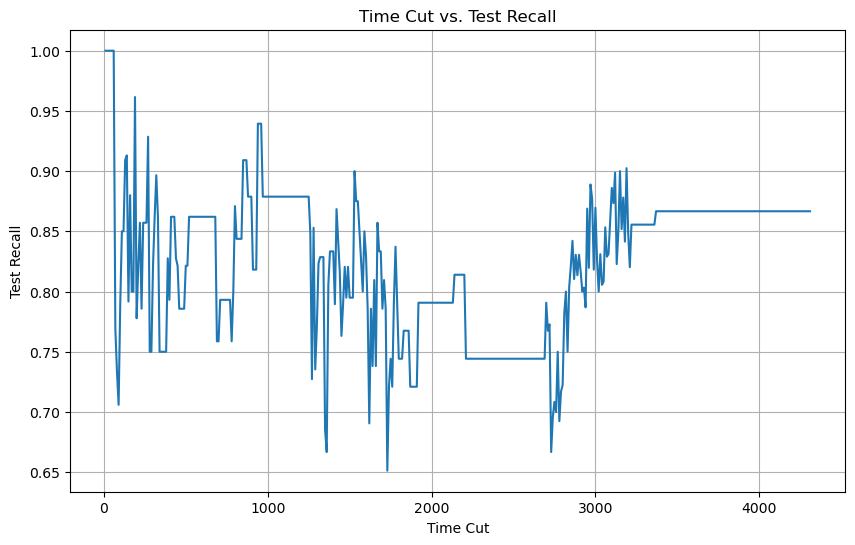

In [39]:

# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_recall', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()

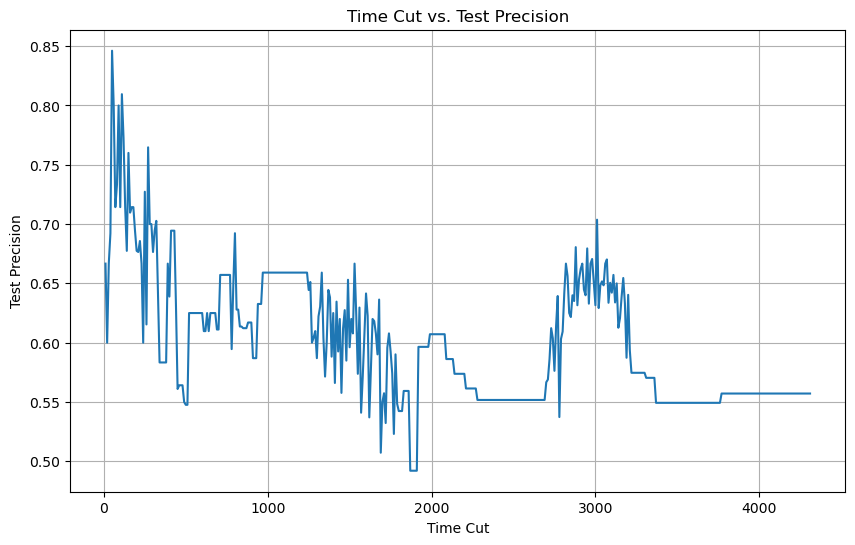

In [40]:
    # Ensure the metrics are numeric
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_precision'] = pd.to_numeric(df['metrics.test_precision'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_precision', data=df)
plt.title('Time Cut vs. Test Precision')
plt.xlabel('Time Cut')
plt.ylabel('Test Precision')
plt.grid(True)
plt.show()